# TGAN

# 라이브러리 다운

In [ ]:
#테이블 평가 라이브러리 다운
!pip install table_evaluator

# 데이터 전처리

In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Cap/realfinaltgan.csv",encoding='CP949')
print(df.columns)

Index(['Age of current', 'PT_FMHS_CNCR_YN', ' BRCA1/BRCA2', 'Height', 'Weight',
       'Weight of 18', 'Body of 7', 'Smoke', 'Type of Drink', 'Age of Menarch',
       'Homone therapy', 'HRT', 'Age at first birth', 'Number of births'],
      dtype='object')


In [ ]:
# data configuration


file_name = "/content/drive/MyDrive/Colab Notebooks/Cap/realfinaltgan.csv"
categorical_features = ['PT_FMHS_CNCR_YN',' BRCA1/BRCA2','Smoke', 'Type of Drink','Homone therapy', 'HRT','Number of births','Body of 7']
continuous_features = ['Age of current','Height', 'Weight',  'Age of Menarch', 'Age at first birth','Weight of 18']

# training configuration
noise_dim = 128
dim = 128
batch_size = 32

log_step = 10
epochs = 100      #무료코랩 환경 내 epochs
learning_rate = 7e-3
models_dir = 'model'

"암을 진단받은 적이 있습니까" 에 대한 설문의 경우 5명의 "그렇다" 답변을 받아 TGAN을 통해 학습 가능한 정도의 데이터를 확보하지 못하였기 때문에 부득이하게 제거하였다. 관련된 진단 연령, 완치여부, 재발 등 칼럼도 함께 제거하였다.
동일한 이유로 충분한 학습 데이터를 확보하지 못한 "자매/어머니 유방암 진단 여부" 역시 제외하였다. 해당 데이터들의 경우 "가족이 암 진단을 받은 적 있는가"에 함께 포함되었다.

흡연의 경우 역시 적은 양의 데이터가 모였으나, (과거)흡연 여부에 대해서는 학습이 가능하여 해당 과정을 진행 뒤, 흡연 경력이 존재한다고 학습된 데이터들에 한하여 설문조사 데이터 내 임의값을 넣어 학습하고자 하였다.

해당 과정들은 엑셀을 이용해 진행됐다.


In [ ]:
df = pd.read_csv(file_name)
print(df.columns)

Index(['Age of current', 'PT_FMHS_CNCR_YN', ' BRCA1/BRCA2', 'Height', 'Weight',
       'Weight of 18', 'Body of 7', 'Smoke', 'Type of Drink', 'Age of Menarch',
       'Homone therapy', 'HRT', 'Age at first birth', 'Number of births'],
      dtype='object')


In [ ]:
for column in categorical_features:
  df[column] = df[column].astype('category').cat.codes

In [ ]:
import numpy as np

for column in continuous_features:
  min = df[column].min()
  max = df[column].max()
  feature_bins = pd.cut(df[column], bins=np.linspace(min, max, 21), labels=False)

In [ ]:
# 각 데이터에 대해 yeo-johnson 정규화 적용
from sklearn.preprocessing import PowerTransformer

df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])
pw= PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
pwt=pw.fit_transform(df[df.columns])

# 모델 학습

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class GAN(nn.Module):
    def __init__(self, gan_args):
        super(GAN, self).__init__()
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size, self.noise_dim, layers_dim, self.data_dim)
        self.discriminator = Discriminator(self.batch_size, self.data_dim, layers_dim)

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=lr)
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=lr)

        self.criterion = nn.BCELoss()

    def get_data_batch(self, train, batch_size, seed=0):
        np.random.seed(seed)
        indices = np.random.randint(0, len(train), batch_size)
        return torch.tensor(train[indices], dtype=torch.float32)

    def train(self, data, train_arguments):
      [cache_prefix, epochs, sample_interval] = train_arguments

      # Adversarial ground truths
      valid = torch.ones((self.batch_size, 1), dtype=torch.float32)
      fake = torch.zeros((self.batch_size, 1), dtype=torch.float32)

      for epoch in range(epochs):
        for _ in range(len(data) // self.batch_size):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            self.optimizer_D.zero_grad()

            real_data = self.get_data_batch(data, self.batch_size)
            real_labels = torch.ones(self.batch_size, 1)
            fake_noise = torch.randn(self.batch_size, self.noise_dim)
            fake_data = self.generator(fake_noise).detach()
            fake_labels = torch.zeros(self.batch_size, 1)

            real_output = self.discriminator(real_data)
            d_loss_real = self.criterion(real_output, real_labels)
            d_loss_real.backward()

            fake_output = self.discriminator(fake_data)
            d_loss_fake = self.criterion(fake_output, fake_labels)
            d_loss_fake.backward()

            self.optimizer_D.step()

            d_loss = d_loss_real + d_loss_fake

            # -----------------
            #  Train Generator
            # -----------------
            self.optimizer_G.zero_grad()

            fake_noise = torch.randn(self.batch_size, self.noise_dim)
            fake_data = self.generator(fake_noise)
            fake_labels = torch.ones(self.batch_size, 1)

            output = self.discriminator(fake_data)
            g_loss = self.criterion(output, fake_labels)
            g_loss.backward()

            self.optimizer_G.step()

            real_accuracy = torch.mean((real_output > 0.5).float())
            fake_accuracy = torch.mean((fake_output <= 0.5).float())
            d_accuracy = 0.5 * (real_accuracy + fake_accuracy)

            print("%d [D loss: %.4f, acc.: %.2f%%] [G loss: %.4f]" % (epoch, d_loss.item(), d_accuracy.item()*100, g_loss.item()))

            if epoch % sample_interval == 0:
            # save model checkpoints
              model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.pt'
              torch.save(self.generator.state_dict(), model_checkpoint_base_name.format('generator', epoch))
              torch.save(self.discriminator.state_dict(), model_checkpoint_base_name.format('discriminator', epoch))

            # generate data
              z = torch.randn(432, self.noise_dim)
              gen_data = self.generator(z)
              print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, "Please provide a valid path. Path must be a directory."
        torch.save(self.generator.state_dict(), os.path.join(path, f'{name}_generator.pth'))
        torch.save(self.discriminator.state_dict(), os.path.join(path, f'{name}_discriminator.pth'))

    def load(self, path):
        assert os.path.isdir(path) == True, "Please provide a valid path. Path must be a directory."
        self.generator.load_state_dict(torch.load(os.path.join(path, 'generator.pth')))
        self.discriminator.load_state_dict(torch.load(os.path.join(path, 'discriminator.pth')))

class Generator(nn.Module):
    def __init__(self, batch_size, input_dim, layers_dim, output_dim):
        super(Generator, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.layers_dim = layers_dim
        self.output_dim = output_dim

        layers = []
        layers.append(nn.Linear(input_dim, layers_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim, layers_dim * 4))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim * 4, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, batch_size, input_dim, layers_dim):
        super(Discriminator, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.layers_dim = layers_dim

        layers = []
        layers.append(nn.Linear(input_dim, layers_dim * 4))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(layers_dim * 4, layers_dim * 2))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(layers_dim * 2, layers_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
data_cols = df.columns

In [ ]:
#Define the GAN and training parameters
df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

14


In [ ]:
!mkdir model
!mkdir model/gan
!mkdir model/gan/saved

In [ ]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df.values, train_args)

0 [D loss: 1.3995, acc.: 50.00%] [G loss: 0.4824]
generated_data
0 [D loss: 2.1571, acc.: 50.00%] [G loss: 0.6364]
generated_data
0 [D loss: 1.3382, acc.: 50.00%] [G loss: 0.8526]
generated_data
0 [D loss: 0.9836, acc.: 100.00%] [G loss: 1.1793]
generated_data
0 [D loss: 0.7260, acc.: 100.00%] [G loss: 1.5466]
generated_data
0 [D loss: 0.4647, acc.: 100.00%] [G loss: 1.7086]
generated_data
0 [D loss: 0.4856, acc.: 100.00%] [G loss: 1.5894]
generated_data
0 [D loss: 0.9073, acc.: 53.12%] [G loss: 1.4393]
generated_data
0 [D loss: 1.0928, acc.: 50.00%] [G loss: 1.3249]
generated_data
0 [D loss: 0.9031, acc.: 62.50%] [G loss: 1.7019]
generated_data
0 [D loss: 0.8335, acc.: 85.94%] [G loss: 2.2375]
generated_data
1 [D loss: 0.9099, acc.: 84.38%] [G loss: 2.4829]
1 [D loss: 0.8569, acc.: 87.50%] [G loss: 2.3834]
1 [D loss: 0.5606, acc.: 87.50%] [G loss: 2.1566]
1 [D loss: 0.5915, acc.: 93.75%] [G loss: 2.0997]
1 [D loss: 1.0209, acc.: 76.56%] [G loss: 3.6266]
1 [D loss: 0.3441, acc.: 93.75%

In [ ]:
#You can easily save the trained generator and loaded it aftwerwards

synthesizer.save('/content/drive/MyDrive/Colab Notebooks/Cap', 'realfinal')

# 데이터 평가

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 12000 # number of fraud cases
noise_dim = 128

np.random.seed(seed)
z = torch.randn(test_size, noise_dim)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)


for model_step_ix, model_step in enumerate(model_steps):

    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_state_dict(torch.load(base_dir + '_generator_model_weights_step_'+str(model_step)+'.pt'))
    generator_model.eval()


    with torch.no_grad():
        g_z = generator_model(z).numpy()

    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('capstone_tgan.csv')

382 12000


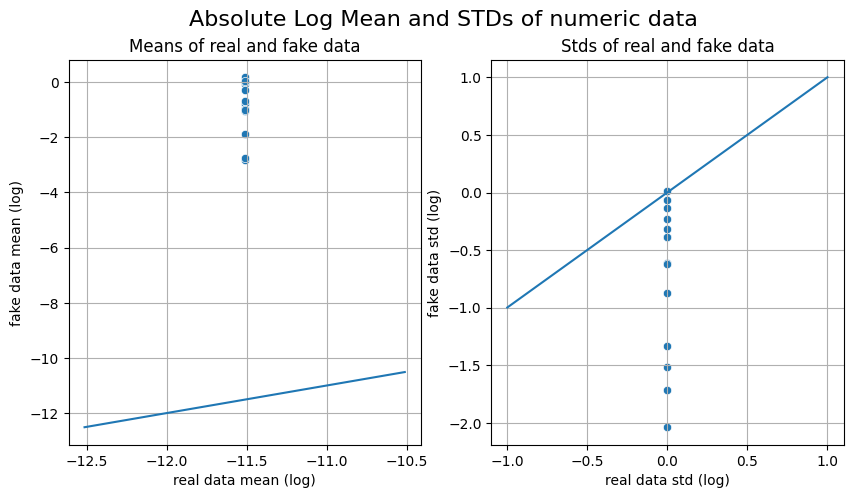

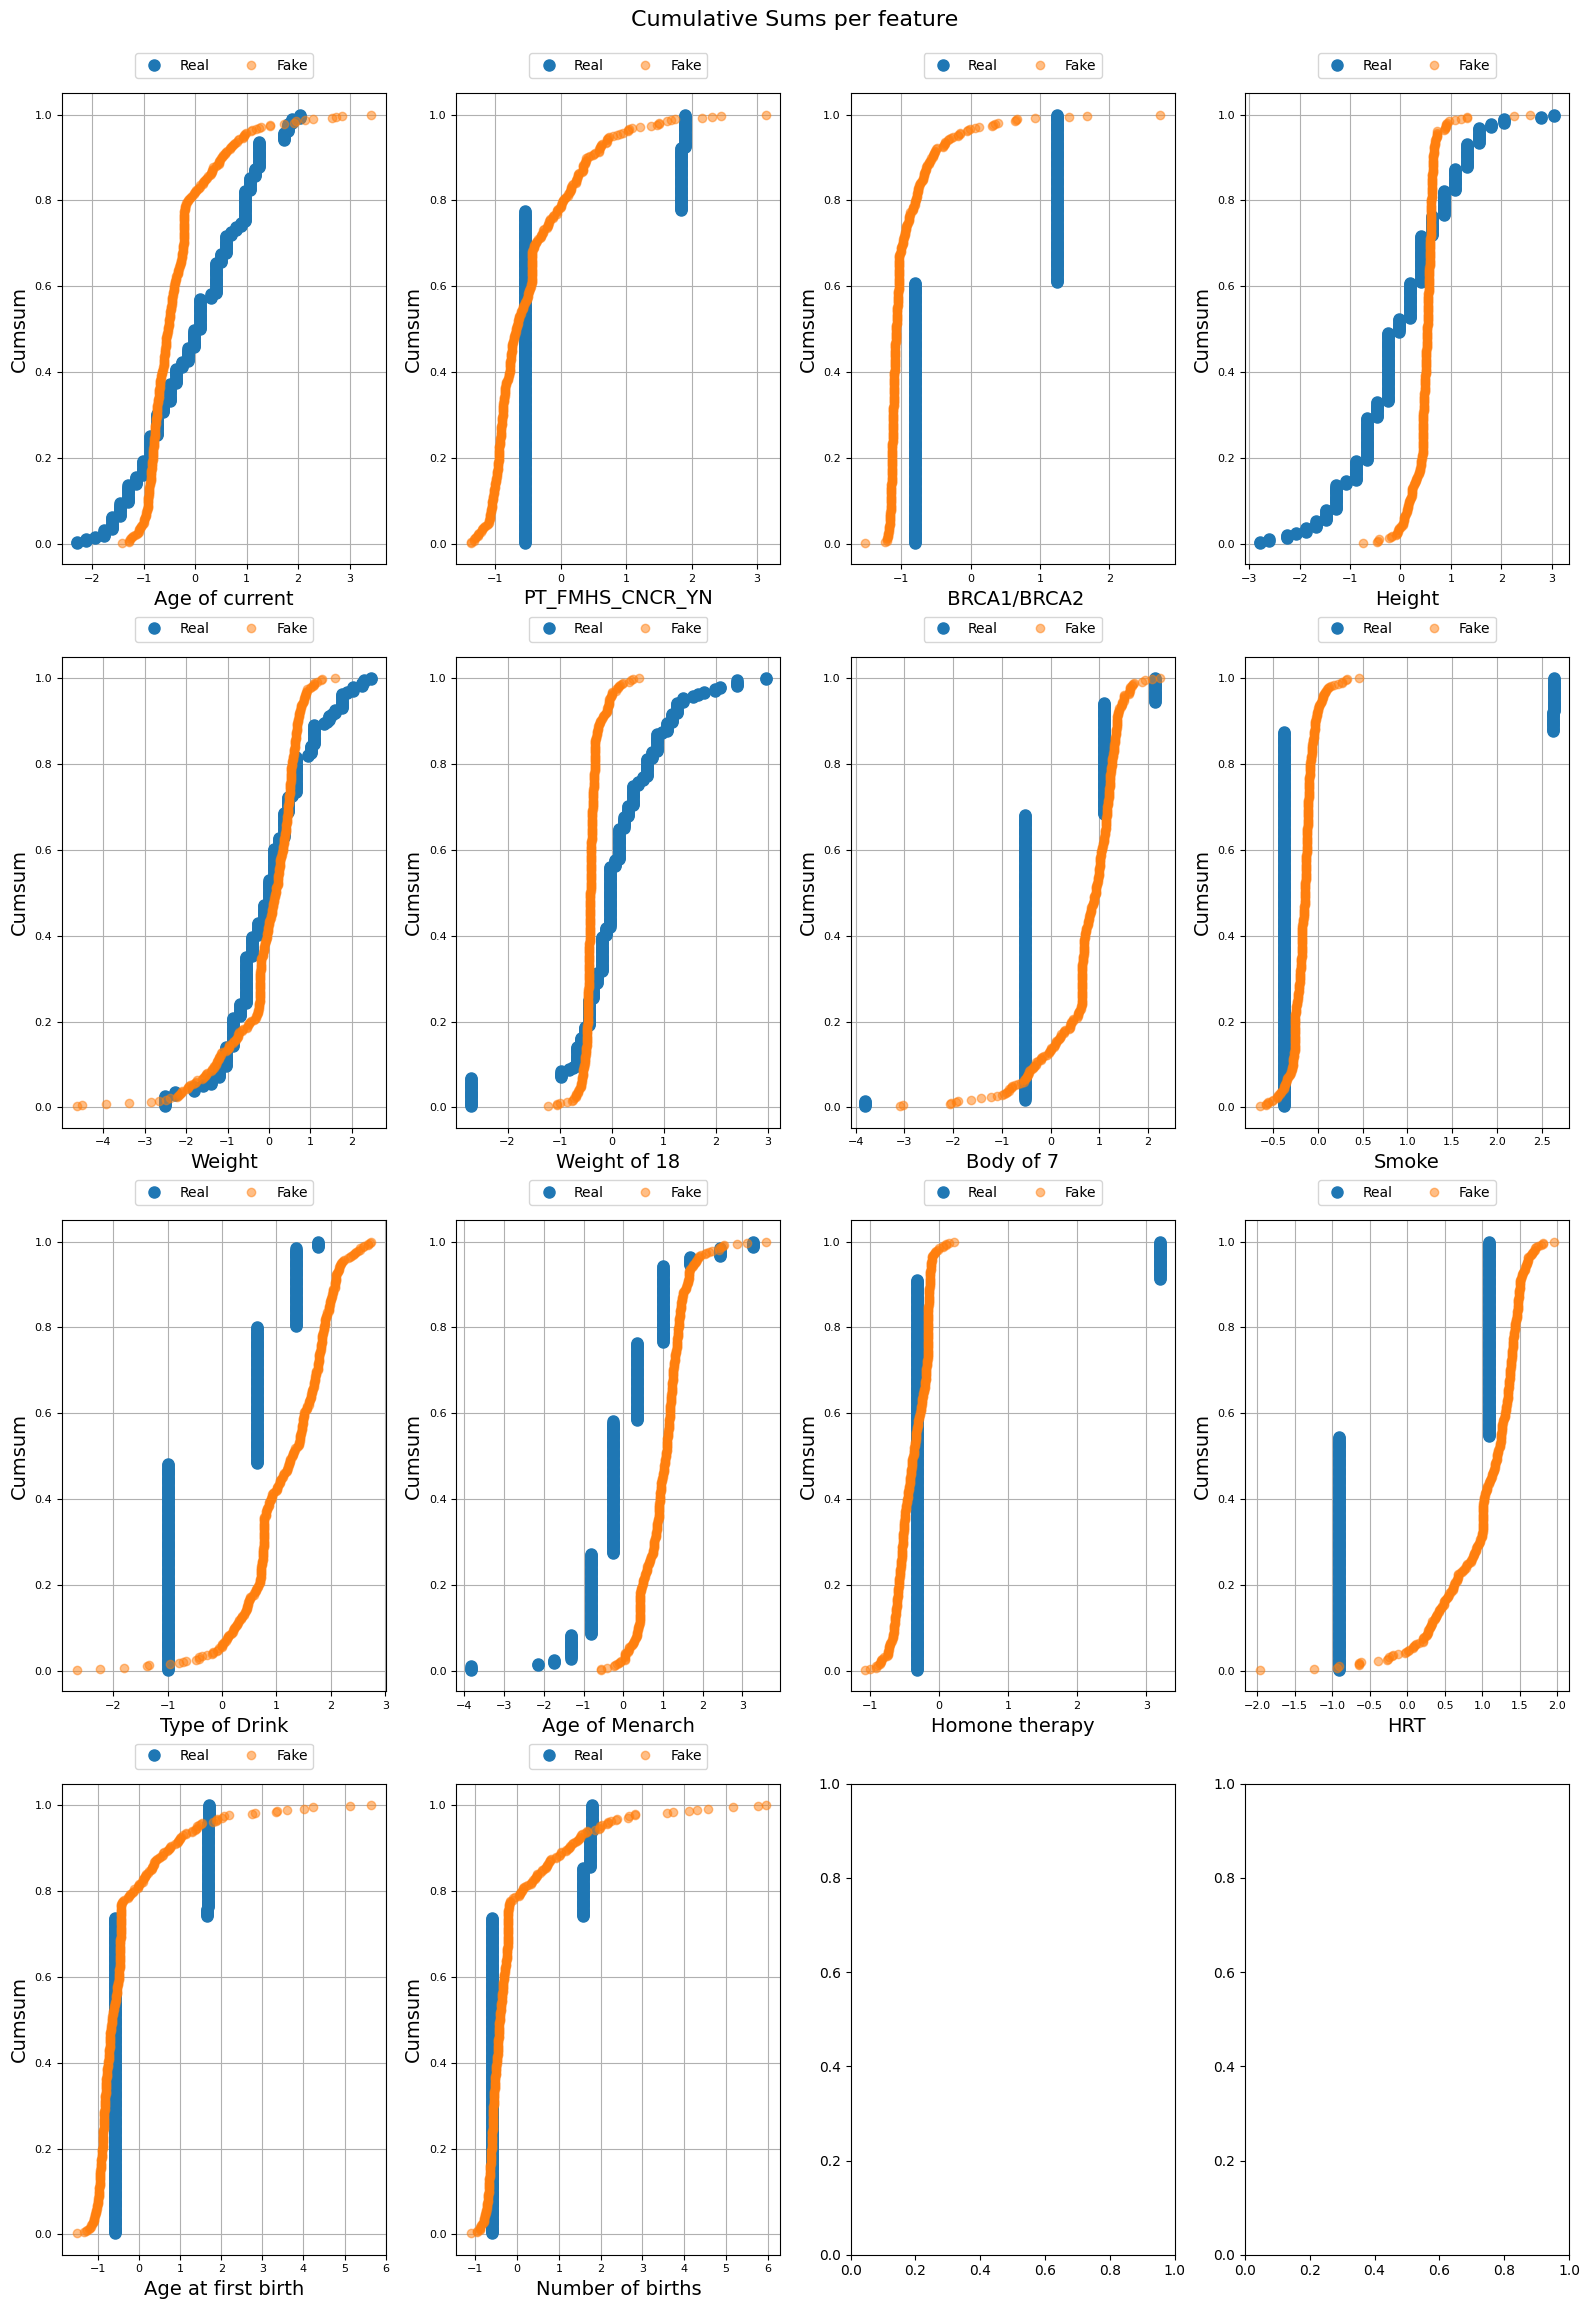

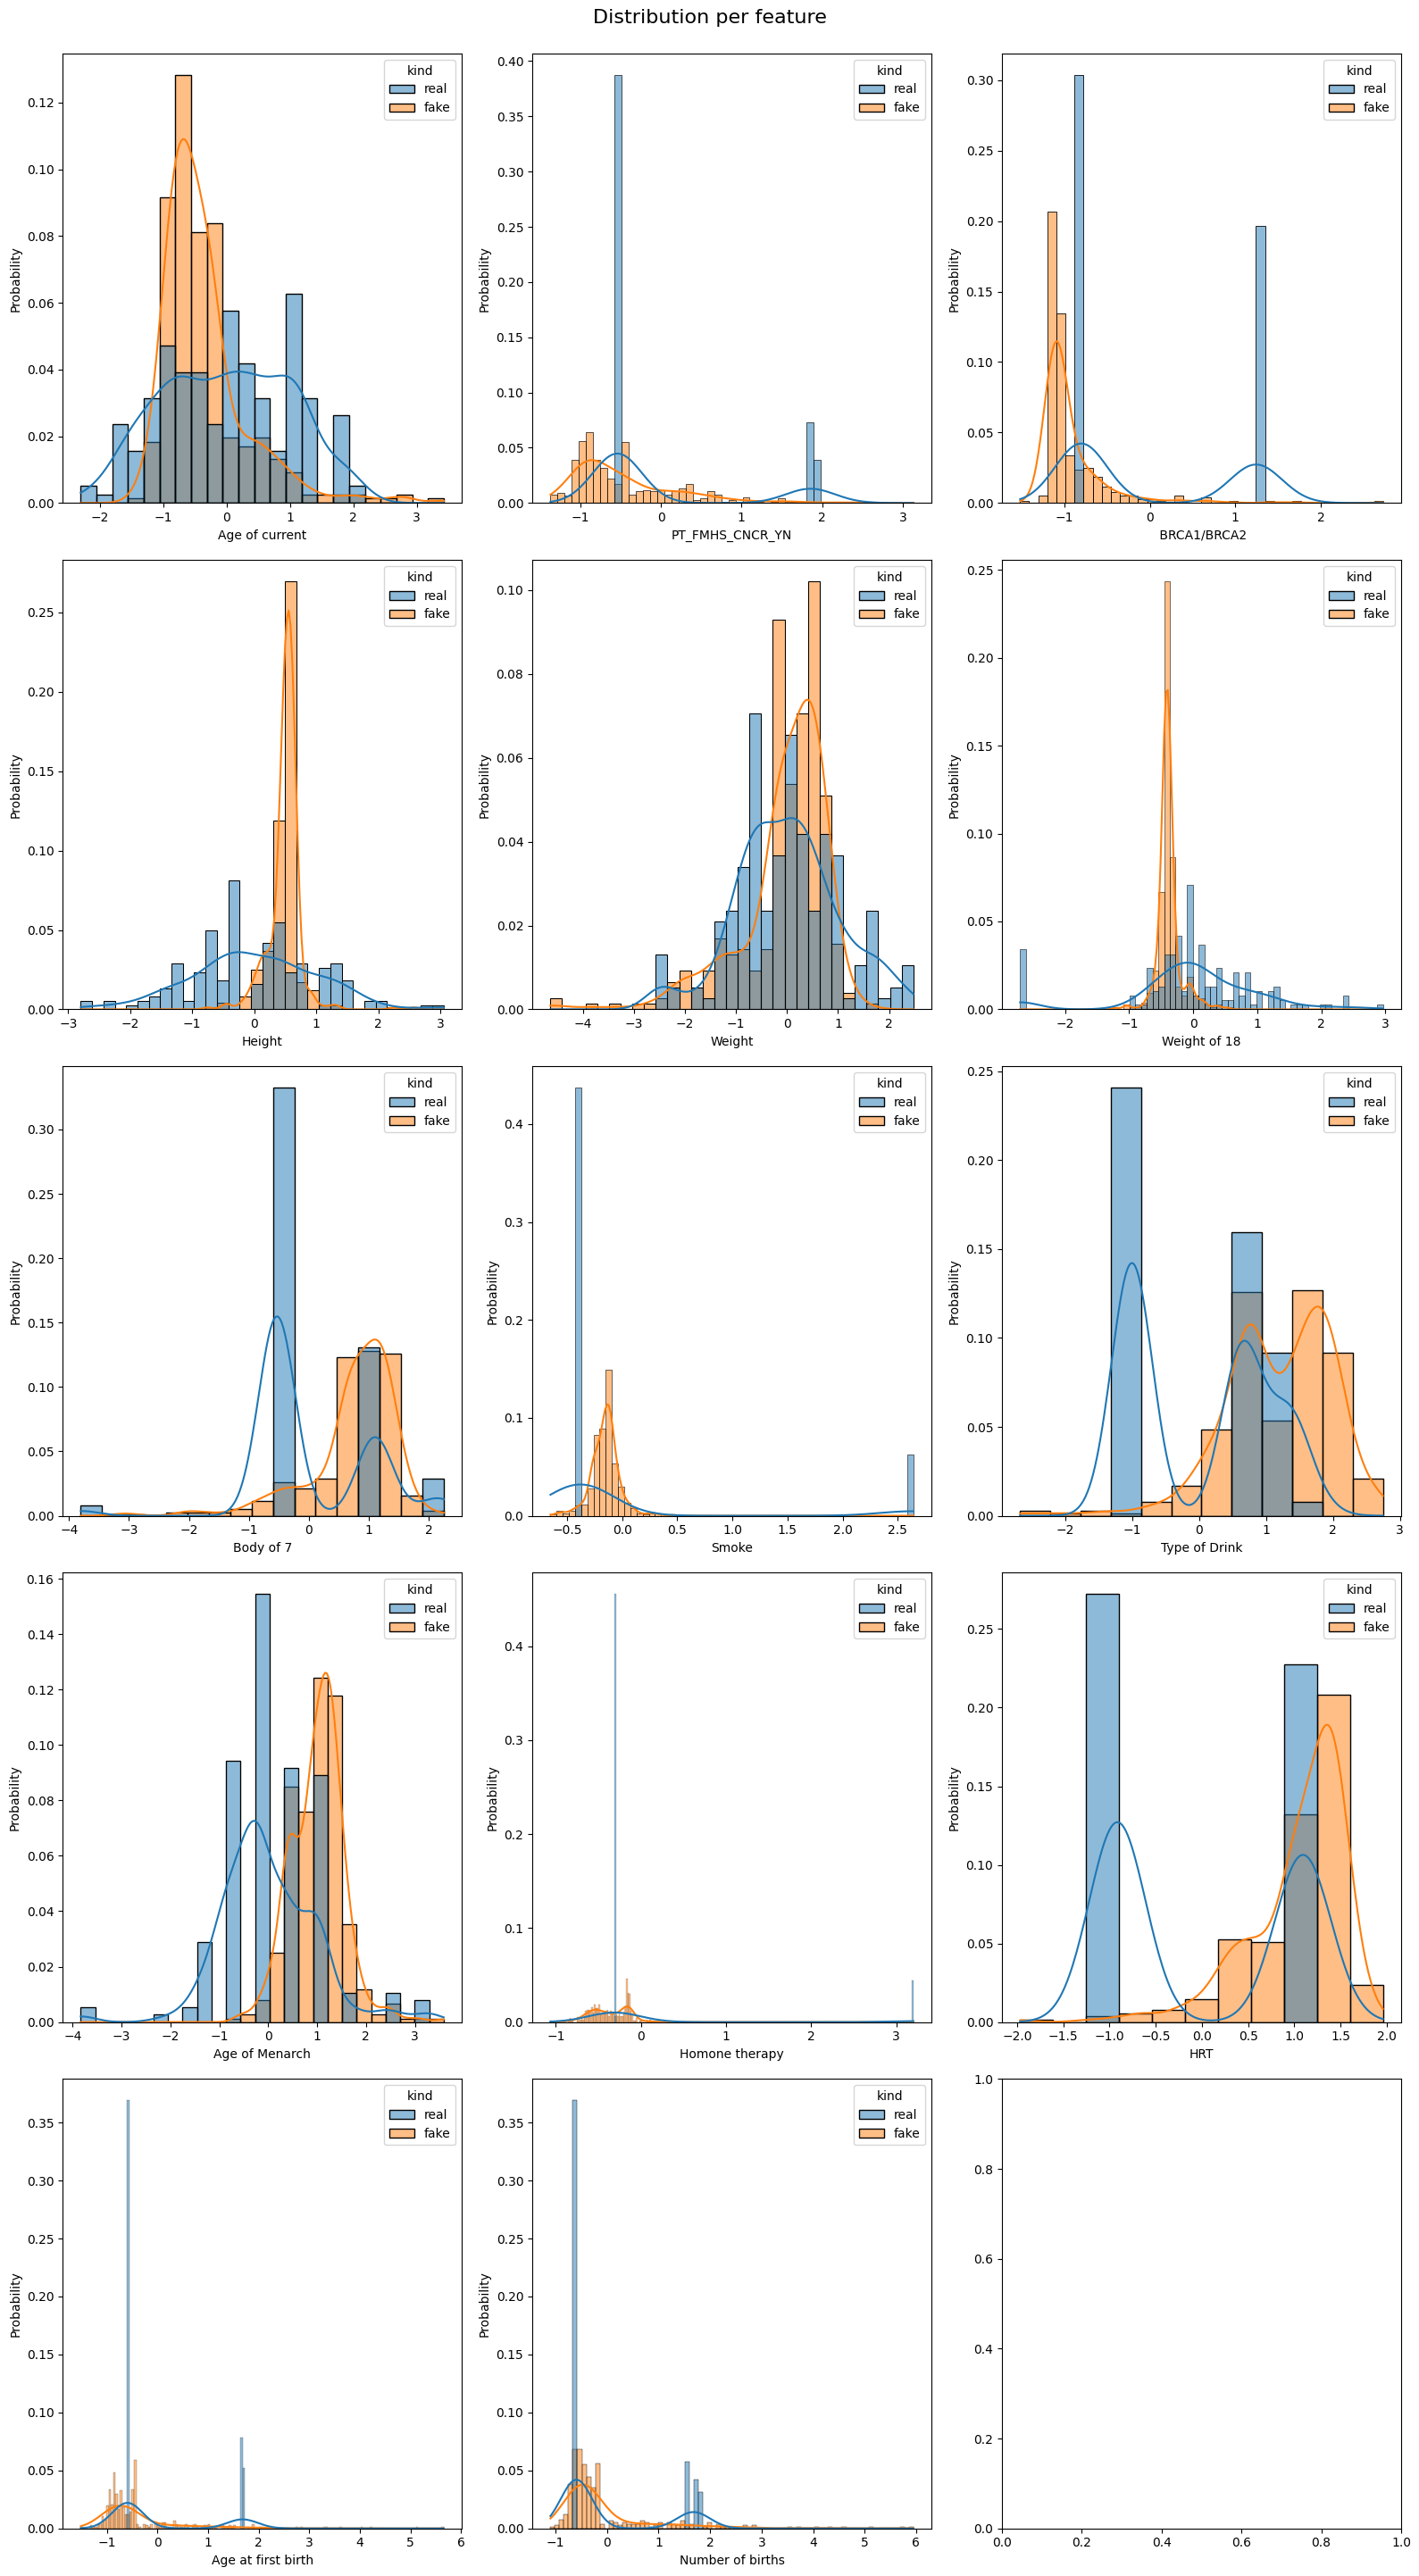

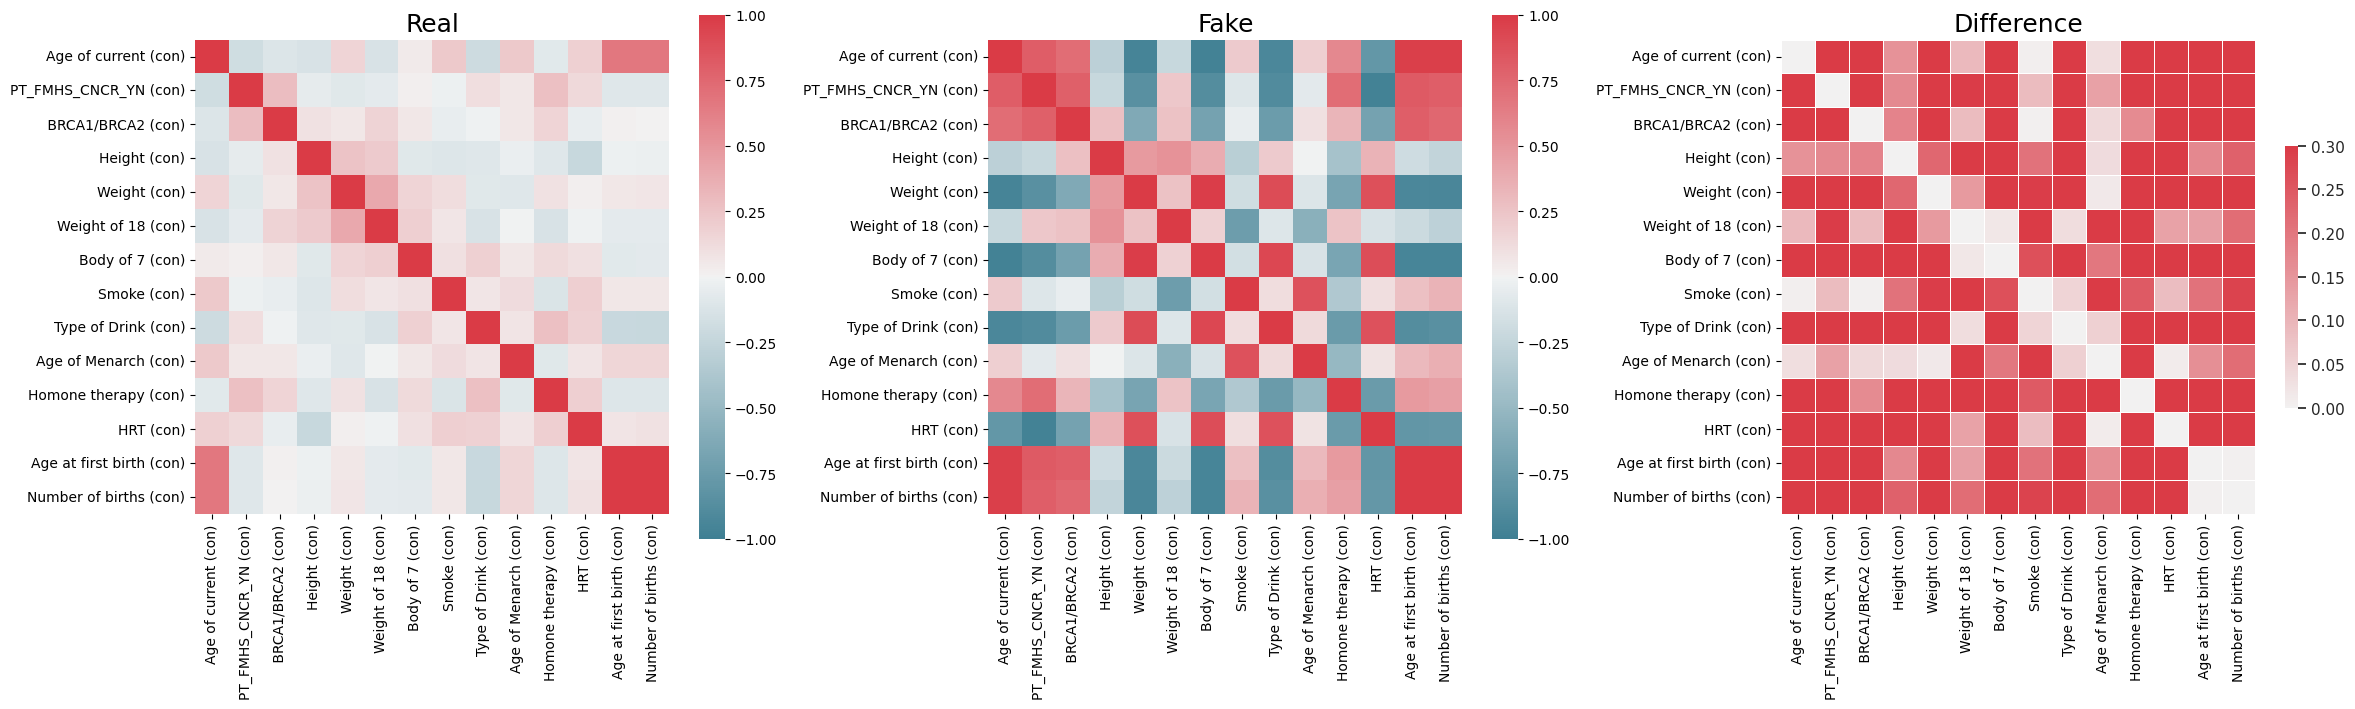

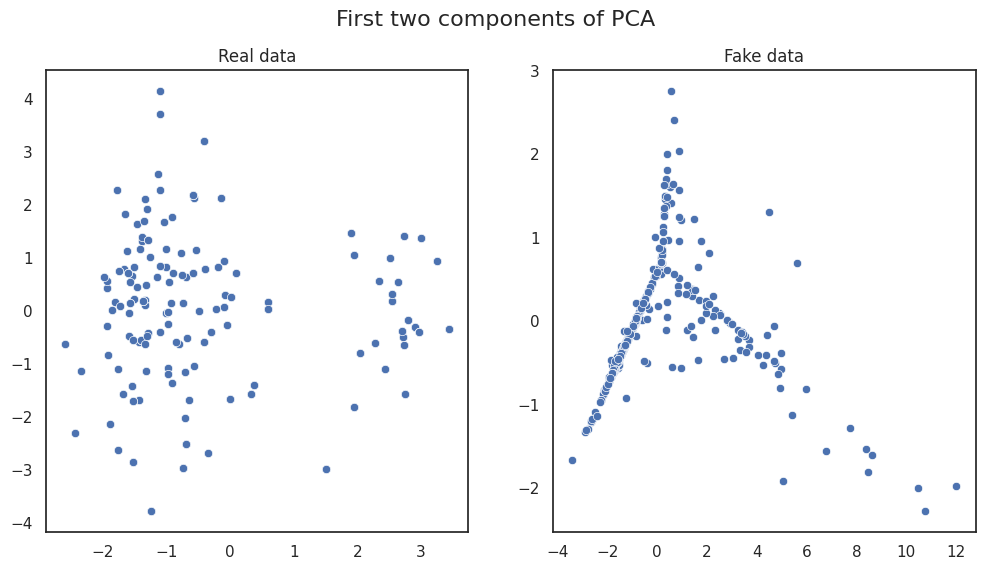

In [ ]:
from table_evaluator import load_data, TableEvaluator

print(len(df), len(gen_samples))
table_evaluator =  TableEvaluator(df, gen_samples)

table_evaluator.visual_evaluation()

# 데이터 범위


In [ ]:
df_tgan = pd.read_csv("/content/capstone_tgan.csv",encoding='CP949')

In [ ]:
# 정규화된 범주형 데이터들에 대해 고유값 반환
def find_unique_values(df, column_name):

    unique_values = df[column_name].unique()
    return unique_values

unique_values_1 = find_unique_values(df, 'PT_FMHS_CNCR_YN')
unique_values_2 = find_unique_values(df, ' BRCA1/BRCA2')
unique_values_3 = find_unique_values(df, 'Smoke')
unique_values_4 = find_unique_values(df, 'Type of Drink')
unique_values_5 = find_unique_values(df, 'Homone therapy')
unique_values_6 = find_unique_values(df, 'HRT')
unique_values_7 = find_unique_values(df, 'Number of births')


print("\nUnique values in column 'PT_FMHS_CNCR_YN':")
print(unique_values_1)
print("\nUnique values in column ' BRCA1/BRCA2':")
print(unique_values_2)
print("\nUnique values in column 'Smoke':")
print(unique_values_3)
print("\nUnique values in column 'Type of Drink':")
print(unique_values_4)
print("\nUnique values in column 'Homone therapy':")
print(unique_values_5)
print("\nUnique values in column 'HRT':")
print(unique_values_6)
print("\nUnique values in column 'Number of births':")
print(unique_values_7)


Unique values in column 'PT_FMHS_CNCR_YN':
[-0.53894604  1.82974899  1.90206945]

Unique values in column ' BRCA1/BRCA2':
[-0.8040844   1.24365054]

Unique values in column 'Smoke':
[-0.37909397  2.64122399  2.63225915]

Unique values in column 'Type of Drink':
[ 0.64644475 -1.00073145  1.35255167  1.76495171]

Unique values in column 'Homone therapy':
[-0.31257183  3.19926462]

Unique values in column 'HRT':
[ 1.09334455 -0.91462477]

Unique values in column 'Number of births':
[-0.59471693  1.56592165  1.74742085  1.7871731 ]


In [ ]:
# 범주형 데이터 역변환

def apply_thresholds(df, columns, thresholds, values):
    num_values = len(values)
    if len(thresholds) == 1:  # 임계치가 하나인 경우
        for column in columns:
            df[column] = df[column].apply(lambda x: values[0] if x < thresholds[0] else values[1])
    elif len(thresholds) == 2:  # 임계치가 두 개인 경우
        for column in columns:
            df[column] = df[column].apply(lambda x: values[0] if x < thresholds[0] else
                                                    values[1] if thresholds[0] <= x < thresholds[1] else
                                                    values[num_values - 1])
    elif len(thresholds) == 3:  # 임계치가 세 개인 경우
        for column in columns:
            df[column] = df[column].apply(lambda x: values[0] if x < thresholds[0] else
                                                    values[1] if thresholds[0] <= x < thresholds[1] else
                                                    values[2] if thresholds[1] <= x < thresholds[2] else
                                                    values[num_values - 1])
    return df

# 적용할 임계치와 값 설정
thresholds1 = [0.65, 1.87]
thresholds2 = [0.22]
thresholds3 = [1.13, 2.64]
thresholds4 = [-0.18, 1, 1.56]
thresholds5 = [1.44]
thresholds6 = [0.09]
thresholds7 = [0.49, 1.66, 1.77]

values1 = [0, 1]
values2 = [0, 1, 2]
values3 = [0, 1, 2]
values4 = [0, 1, 2, 3]
values5 = [0, 1, 2]
values6 = [0, 1, 1]
values7 = [0, 1, 2, 3]

# 'A', 'B', 'C' 열에 대해 임계치 적용
columns_to_update1 = ['PT_FMHS_CNCR_YN']
df_tgan = apply_thresholds(df_tgan, columns_to_update1, thresholds1, values1)
columns_to_update2 = [' BRCA1/BRCA2']
df_tgan = apply_thresholds(df_tgan, columns_to_update2, thresholds2, values2)
columns_to_update3 = ['Smoke']
df_tgan = apply_thresholds(df_tgan, columns_to_update3, thresholds3, values3)
columns_to_update4 = ['Type of Drink']
df_tgan = apply_thresholds(df_tgan, columns_to_update4, thresholds4, values4)
columns_to_update5 = ['Homone therapy']
df_tgan = apply_thresholds(df_tgan, columns_to_update5, thresholds5, values5)
columns_to_update6 = ['HRT']
df_tgan = apply_thresholds(df_tgan, columns_to_update6, thresholds6, values6)
columns_to_update7 = ['Number of births']
df_tgan = apply_thresholds(df_tgan, columns_to_update7, thresholds7, values7)

print("\nUpdated DataFrame:")
print(df_tgan)


Updated DataFrame:
       Unnamed: 0  Age of current  PT_FMHS_CNCR_YN   BRCA1/BRCA2    Height  \
0               0       -0.672363                0             0  0.568544   
1               1       -0.769752                0             0  0.594824   
2               2       -1.064903                0             0  0.674470   
3               3       -0.377589                0             0  0.586653   
4               4       -0.211599                0             0  0.444207   
...           ...             ...              ...           ...       ...   
11995       11995       -0.296566                0             0  0.503774   
11996       11996       -0.702913                0             0  0.530057   
11997       11997        2.004796                1             0 -0.136918   
11998       11998       -0.799125                0             0  0.380448   
11999       11999        0.071804                0             0  0.329585   

         Weight  Weight of 18  Body of 7  S

In [ ]:
# 흡연자, 아이를 가진 사람 있는지 확인

def count_values_above_threshold(df, column_name, threshold):
    count = 0
    for value in df[column_name]:
        if value >= threshold:
            count += 1
    return count
column_name = 'Smoke'
threshold = 1
count_above_threshold = count_values_above_threshold(df_tgan, column_name, threshold)
print(f"Number of values above {threshold} in column '{column_name}': {count_above_threshold}")

column_name = 'Number of births'
threshold = 1
count_above_threshold = count_values_above_threshold(df_tgan, column_name, threshold)
print(f"Number of values above {threshold} in column '{column_name}': {count_above_threshold}")

Number of values above 1 in column 'Smoke': 9
Number of values above 1 in column 'Number of births': 1985


In [ ]:
# 연속형 데이터 역변환

from scipy.stats import johnsonsb, johnsonsu

def scale_to_custom_range_with_johnson(df, column_name, min_val, max_val):
    # 현재 데이터의 최솟값과 최댓값 계산
    current_min = df[column_name].min()
    current_max = df[column_name].max()

    # 여존슨 분포의 누적 분포 함수 계산
    johnson_params = johnsonsu.fit(df[column_name])
    cdf = johnsonsu.cdf(df[column_name], *johnson_params)

    # 새로운 범위에 대응하는 값 계산
    scaled_values = min_val + cdf * (max_val - min_val)

    # 결과를 데이터프레임에 저장
    df[column_name] = scaled_values.round(1)

    return df

df_tgant = scale_to_custom_range_with_johnson(df_tgan, 'Age of current', 10, 70)
df_tgant = scale_to_custom_range_with_johnson(df_tgan, 'Height', 145, 175)
df_tgant = scale_to_custom_range_with_johnson(df_tgan, 'Weight', 40, 95)
df_tgant = scale_to_custom_range_with_johnson(df_tgan, 'Age of Menarch', 9, 18)
df_tgant = scale_to_custom_range_with_johnson(df_tgan, 'Age at first birth', 20, 40)

#사용하지 않는 칼럼 제외
df_tgant = df_tgant.drop('Weight of 18', axis=1)
df_tgant = df_tgant.drop('Body of 7', axis=1)
print("\nUpdated DataFrame:")
print(df_tgant)


Updated DataFrame:
       Unnamed: 0  Age of current  PT_FMHS_CNCR_YN   BRCA1/BRCA2  Height  \
0               0            32.4                0             0   163.8   
1               1            26.2                0             0   168.7   
2               2            12.6                0             0   172.3   
3               3            47.4                0             0   166.4   
4               4            53.0                0             0   153.6   
...           ...             ...              ...           ...     ...   
11995       11995            50.4                0             0   158.6   
11996       11996            29.8                0             0   161.1   
11997       11997            68.9                1             0   146.1   
11998       11998            24.4                0             0   150.9   
11999       11999            59.1                0             0   149.7   

       Weight  Smoke  Type of Drink  Age of Menarch  Homone therapy

In [ ]:
def replace_column_value(df, target_column, condition_column, condition_value, replacement_value):
    # 특정 열의 값이 0인 경우, 대상 열 값을 대체 값으로 설정
    df.loc[(df[target_column] == 0) & (df[condition_column] == condition_value), target_column] = replacement_value
    return df

df_replaced = replace_column_value(df_tgant, 'Age at first birth', 'Number of births', 0, 0)

column_name = 'Number of births'
threshold = 1
count_above_threshold = count_values_above_threshold(df_tgant, column_name, threshold)
print(f"Number of values above {threshold} in column '{column_name}': {count_above_threshold}")

Number of values above 1 in column 'Number of births': 1985


In [ ]:
df_replaced.to_csv('capstone_tgan_final.csv')